# Imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

np.random.seed(0)

In [2]:
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torchtrace.plotann as plotann

In [3]:
TF = 'tf'
NP = 'np'
TORCH = 'torch'

framework = TORCH

In [4]:
if framework == TORCH:
    import torch
    import torch.nn as nn
    from torchvision import datasets
    
if framework == TF:
    import tensorflow as tf
    from tensorflow.examples.tutorials.mnist import input_data

# Load Data

In [5]:
def one_hot(a, nb_classes):
    assert a.ndim == 1
    N = len(a)
    M = nb_classes
    result = np.zeros((N, M), dtype=a.dtype)
    result[range(N), a] = 1
    return result

In [6]:
if framework in [NP, TORCH]:
    
    dataset_location = '~/.pytorch/MNIST_data/'
    
    trainset = datasets.MNIST(dataset_location, download=True, train=True)
    validset = datasets.MNIST(dataset_location, download=True, train=False)
    
    train_x_raw = trainset.data.float().numpy().reshape((-1,784)) / 255
    train_y_raw = one_hot(trainset.targets.numpy(), 10).astype(np.float32)
    valid_x_raw = validset.data.float().numpy().reshape((-1,784)) / 255
    valid_y_raw = one_hot(validset.targets.numpy(), 10).astype(np.float32)

In [7]:
if framework == TF:
    
    mnist = input_data.read_data_sets('MNIST-Dataset', one_hot=True)
    
    train_x_raw = np.concatenate((mnist.train.images, mnist.validation.images))
    train_y_raw = np.concatenate((mnist.train.labels.astype(np.float32),
                                  mnist.validation.labels.astype(np.float32)))
    valid_x_raw = mnist.test.images
    valid_y_raw = mnist.test.labels.astype(np.float32)

**Show statistics**

In [8]:
def print_help(a):
    print(f's: {str(a.shape):15} t:{str(a.dtype):7} {a.min():6.2f} {a.max():6.2f} {a.mean():6.2f} {a.std():6.2f}')

In [9]:
print_help(train_x_raw)
print_help(train_y_raw)
print_help(valid_x_raw)
print_help(valid_y_raw)

s: (60000, 784)    t:float32   0.00   1.00   0.13   0.31
s: (60000, 10)     t:float32   0.00   1.00   0.10   0.30
s: (10000, 784)    t:float32   0.00   1.00   0.13   0.31
s: (10000, 10)     t:float32   0.00   1.00   0.10   0.30


## Explore Data

In [10]:
def plot_mnist(data_x, data_y, n):
    fig = plt.figure(figsize=[16,9])
    for i in range(n):
        ax = fig.add_subplot(n//8, 8, i+1)
        ax.imshow(data_x[i].reshape([28,28]))
        ax.axis('off')
        idx = int(np.nonzero(data_y[i])[0])
        ax.set_title(idx)
    plt.show()

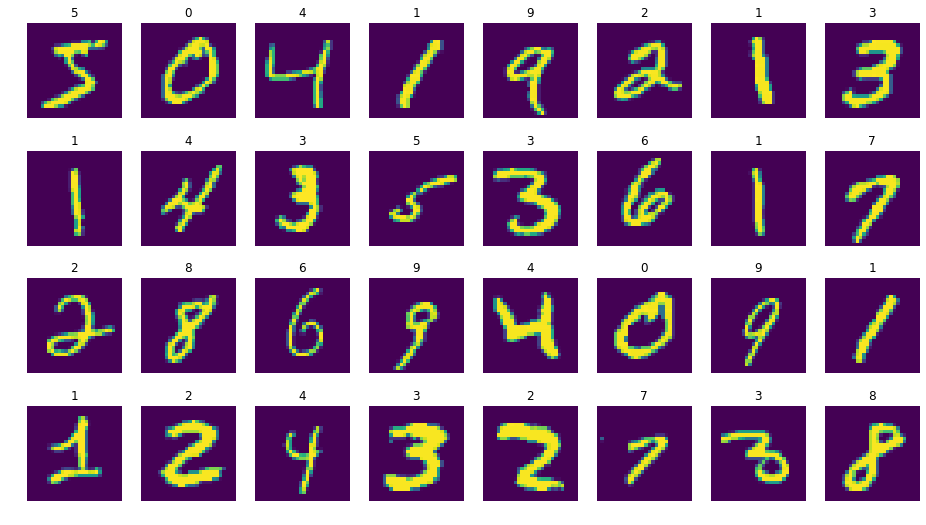

In [11]:
plot_mnist(train_x_raw, train_y_raw, 32)

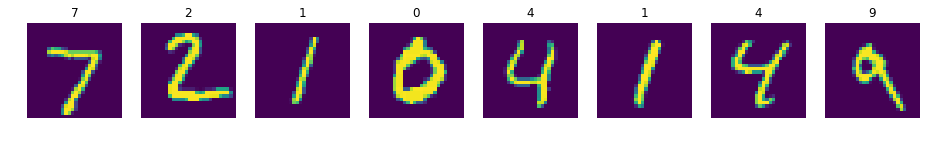

In [12]:
plot_mnist(valid_x_raw, valid_y_raw, 8)

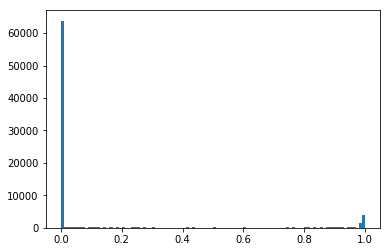

In [13]:
plt.hist(train_x_raw[0:100].flatten(), bins=100);

In [14]:
print('train mean:', train_x_raw.mean(), 'std', train_x_raw.std())
print('valid mean:', valid_x_raw.mean(), 'std', valid_x_raw.std())

train mean: 0.13066062 std 0.30810776
valid mean: 0.13251467 std 0.31048027


## Preprocess Data

In [15]:
tx_mean = train_x_raw.mean()
tx_std = train_x_raw.std()
train_x = (train_x_raw - tx_mean)/tx_std
valid_x = (valid_x_raw - tx_mean)/tx_std
train_y = train_y_raw
valid_y = valid_y_raw
print('train mean:', train_x.mean(), 'std', train_x.std())
print('valid mean:', valid_x.mean(), 'std', valid_x.std())
print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)

train mean: -5.1035363e-07 std 0.99999946
valid mean: 0.0060172975 std 1.0077002
(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


In [16]:
tx_mean = train_x_raw.mean()
tx_std = train_x_raw.std()
train_x = (train_x_raw - tx_mean)/tx_std
valid_x = (valid_x_raw - tx_mean)/tx_std
train_y = train_y_raw
valid_y = valid_y_raw
print('train mean:', train_x.mean(), 'std', train_x.std())
print('valid mean:', valid_x.mean(), 'std', valid_x.std())
print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)

train mean: -5.1035363e-07 std 0.99999946
valid mean: 0.0060172975 std 1.0077002
(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


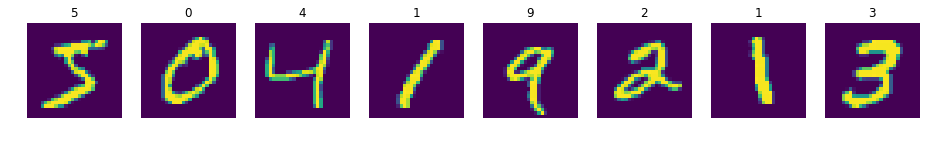

In [17]:
plot_mnist(train_x, train_y, 8)

In [18]:
def subsample_to_14_14(data):
    assert data.ndim == 2
    assert data.shape[1] == 784
    data_28x28 = data.reshape([len(data), 28, 28])  # reshape to match image resolution, new shape (nb_samples, 28, 28)
    print('28', data_28x28.shape)
    data_14x14 = data_28x28[:,::2,::2] # subsample, new shape (nb_samples, 14, 14)
    print('14', data_14x14.shape)
    data_196 = data_14x14.reshape([len(data),14*14])
    print('data_196', data_196.shape)
    assert data_196.ndim == 2
    assert data_196.shape[1] == 196
    return data_196

In [19]:
train_x = subsample_to_14_14(train_x)
valid_x = subsample_to_14_14(valid_x)

28 (60000, 28, 28)
14 (60000, 14, 14)
data_196 (60000, 196)
28 (10000, 28, 28)
14 (10000, 14, 14)
data_196 (10000, 196)


In [20]:
assert train_x.shape == (60000, 196) and train_x.dtype == np.float32
assert train_y.shape == (60000, 10)  and train_y.dtype == np.float32
assert valid_x.shape == (10000, 196) and valid_x.dtype == np.float32
assert valid_y.shape == (10000, 10)  and valid_y.dtype == np.float32

# NumPy Model

In [ ]:
def sigmoid(x, deriv=False):
    if deriv:
        return sigmoid(x)*(1-sigmoid(x))
    return 1 / (1 + np.exp(-x))

def tanh(x, deriv=False):
    if deriv:
        return 1. - np.tanh(x)**2
    return np.tanh(x)

def softssign(x, deriv=False):
    if deriv:
        dd = 1 + np.abs(x)
        return (dd - x*np.sign(x)) / dd**2
    return x / (1+np.abs(x))

def relu(x, deriv=False):
    if deriv:
        return 1. * (x>0)
    return np.maximum(0, x)

def lrelu(x, deriv=False):
    if deriv:
        dx = np.ones_like(x)
        dx[x < 0] = 0.01
        return dx
    return np.where(x > 0, x, x * 0.01)

act_fun_dict = {'sigmoid': sigmoid, 'tanh': tanh, 'softssign':softssign,
                'relu':relu, 'lrelu':lrelu}

In [ ]:
def MSE(y, y_hat):
    assert y.ndim == 2
    assert y_hat.ndim == 2
    
    # avg over batch, sum over outputs (inner)
    return .5 * np.mean(np.sum((y-y_hat)**2, axis=-1))
    
    # no innner sum, becouse only one output
    return np.mean((y-y_hat)**2)

def accuracy(y, y_hat):
    return np.mean(np.argmax(y_hat, axis=-1)==np.argmax(y, axis=-1))

def fwd(x, W_hid, W_out, act_fun, ret=False):
    assert x.ndim == 2
    z_hid = x @ W_hid
    h_hid = act_fun(z_hid)  # hidden output

    z_out = h_hid @ W_out
    y_hat = sigmoid(z_out)  # SIGMOID!

    if ret:
        return y_hat, z_hid, h_hid, z_out
    return y_hat

def backprop(x, y, W_hid, W_out, act_fun):
    assert x.ndim == 2
    assert y.ndim == 2
    
    y_hat, z_hid, h_hid, z_out = fwd(x, W_hid, W_out, act_fun, ret=True)
    
    ro_out = (y-y_hat) * -1 * sigmoid(z_out, deriv=True)  # SIGMOID
    dW_out = h_hid.T @ ro_out / len(x)
    
    ro_hid = (ro_out @ W_out.T) * act_fun(z_hid, deriv=True)
    dW_hid = x.T @ ro_hid / len(x)
    
    return dW_hid, dW_out

### Numerical gradient check (optional)

In [ ]:
def ngrad(x, y, W_hid, W_out, act_fun):
    
    eps = 1e-6
    
    gW_hid = np.zeros_like(W_hid)
    for r in range(W_hid.shape[0]):
        for c in range(W_hid.shape[1]):
            W_hid_plus = W_hid.copy()
            W_hid_minus = W_hid.copy()
            W_hid_plus[r,c] += eps
            W_hid_minus[r,c] -= eps
            loss_plus = MSE(y, fwd(x, W_hid_plus, W_out, act_fun))
            loss_minus = MSE(y, fwd(x, W_hid_minus, W_out, act_fun))
            gW_hid[r,c] = (loss_plus-loss_minus) / (2*eps)

    gW_out = np.zeros_like(W_out)
    for r in range(W_out.shape[0]):
        for c in range(W_out.shape[1]):
            W_out_plus = W_out.copy()
            W_out_minus = W_out.copy()
            W_out_plus[r,c] += eps
            W_out_minus[r,c] -= eps
            loss_plus = MSE(y, fwd(x, W_hid, W_out_plus, act_fun))
            loss_minus = MSE(y, fwd(x, W_hid, W_out_minus, act_fun))
            gW_out[r,c] = (loss_plus-loss_minus) / (2*eps)
    return gW_hid, gW_out

In [ ]:
hid_dW, out_dW = backprop(train_x[0:3], train_y[0:3], W_hid, W_out, act_fun)
hid_ngW, out_ngW = ngrad(train_x[0:3], train_y[0:3], W_hid, W_out, act_fun)

In [ ]:
assert np.allclose(hid_dW, hid_ngW)
assert np.allclose(out_dW, out_ngW)

# Train Loop - with traces

In [ ]:
class ModelNP:
    def __init__(self, n_in, n_hid, n_out, lr, W_hid, W_out, act_fun):
        
        self.hid_W = W_hid.copy()
        self.out_W = W_out.copy()
        self.act_fun = act_fun
        
    def train_batch(self, x, y):
        
        # Forward pass
        y_hat, hid_z, _, out_z = fwd(x, self.hid_W, self.out_W,
                                     act_fun_dict[self.act_fun], ret=True)
        loss = MSE(y, y_hat)
        acc = accuracy(y, y_hat)
        
        assert y_hat.shape == y.shape
        assert np.isscalar(loss)
        assert np.isscalar(acc)

        # Backpropagation
        hid_dW, out_dW = backprop(x, y, self.hid_W, self.out_W,
                                  act_fun_dict[self.act_fun])
        
        self.hid_W += -lr * hid_dW
        self.out_W += -lr * out_dW

        metrics = {'loss': loss, 'acc': acc}
        trace = {'hid_z': hid_z, 'out_z': out_z,
                 'hid_dW': hid_dW, 'out_dW': out_dW,
                 'hid_W': self.hid_W.copy(), 'out_W': self.out_W.copy()}
        
        return y_hat, metrics, trace

    def eval_batch(self, x, y):
    
        y_hat = fwd(x, self.hid_W, self.out_W, act_fun_dict[self.act_fun])
        loss = MSE(y, y_hat)
        acc = accuracy(y, y_hat)
        
        assert y_hat.shape == y.shape
        assert np.isscalar(loss)
        assert np.isscalar(acc)
        
        metrics = {'loss': loss, 'acc': acc}
        
        return y_hat, metrics

In [22]:
class ModelTorch(nn.Module):
    def __init__(self, n_in, n_hid, n_out, lr, W_hid, W_out):
        super(ModelTorch, self).__init__()
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.lin1 = nn.Linear(in_features=n_in, out_features=n_hid, bias=False)
        self.lin1.weight.data = torch.tensor(W_hid.T, dtype=torch.float32)
        self.act1 = nn.ReLU()
        
        self.lin2 = nn.Linear(in_features=n_hid, out_features=n_out, bias=False)
        self.lin2.weight.data = torch.tensor(W_out.T, dtype=torch.float32)
        self.act2 = nn.Sigmoid()
        
        self.to(self.device)
        
        self.criterion = nn.MSELoss(reduction='sum')
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        
    def accuracy(self, y, y_hat):
        return (torch.argmax(y_hat, dim=-1) == torch.argmax(y, dim=-1)).float().mean()
        
    def forward(self, x, ret=False):
        z_hid = self.lin1(x)
        h_hid = self.act1(z_hid)
        z_out = self.lin2(h_hid)
        y_hat = self.act2(z_out)
    
        if ret:
            return y_hat, z_hid, h_hid, z_out
        return y_hat

    def train_batch(self, x, y):
                
        x_tensor = torch.tensor(x).to(self.device)
        y_tensor = torch.tensor(y).to(self.device)
        
        self.train()
        
        self.optimizer.zero_grad()
        y_hat, z_hid, _, z_out = self(x_tensor, ret=True)
        loss = self.criterion(y_hat, y_tensor)
        loss = loss / len(x) / 2.0  # calc loss same way as NP and TF exampless
        loss.backward()
        
        self.optimizer.step()
        
        with torch.no_grad():
            acc = self.accuracy(y_hat, y_tensor)
        
        y_hat = y_hat.detach().cpu().numpy()
        assert y_hat.shape == y.shape

        metrics = {'loss': loss.item(),
                   'acc': acc.item()}
        
        trace = {'hid_z': z_hid.detach().cpu().numpy().copy(),
                 'out_z': z_out.detach().cpu().numpy().copy(),
                 'hid_dW': self.lin1.weight.grad.cpu().numpy().T.copy(),
                 'out_dW': self.lin2.weight.grad.cpu().numpy().T.copy(),
                 'hid_W': self.lin1.weight.detach().cpu().numpy().T.copy(),
                 'out_W': self.lin2.weight.detach().cpu().numpy().T.copy()}
        
        return y_hat, metrics, trace
    
    def eval_batch(self, x, y):
        
        x_tensor = torch.tensor(x).to(self.device)
        y_tensor = torch.tensor(y).to(self.device)
        
        self.eval()
        
        with torch.no_grad():
        
            y_hat = self(x_tensor)
            loss = self.criterion(y_hat, y_tensor)
            loss = loss / len(x) / 2.0  # calc loss same way as NP and TF exampless
            acc = self.accuracy(y_hat, y_tensor)
            
        y_hat = y_hat.detach().cpu().numpy()
    
        assert y_hat.shape == y.shape

        
        metrics = {'loss': loss.item(), 'acc': acc.item()}
        
        return y_hat, metrics

In [ ]:
class ModelTF:
    def __init__(self, n_in, n_hid, n_out, lr, W_hid, W_out):
        
        print('Initializing TensorFlow graph - High Level API')

        try:    self.sess.close()
        except: pass
        
        tf.reset_default_graph()

        self.nn_x = tf.placeholder(shape=[None, n_in], dtype=tf.float32)
        self.nn_y = tf.placeholder(shape=[None, n_out], dtype=tf.float32)

        self.nn_hid_h = tf.layers.dense(inputs=self.nn_x,
                                        units=n_hid,
                                        activation=tf.nn.relu,
                                        use_bias=False,
                                        kernel_initializer=tf.constant_initializer(W_hid),
                                        name='Hidden')
        self.nn_hid_z = tf.get_default_graph().get_tensor_by_name('Hidden/MatMul:0')

        self.nn_y_hat = tf.layers.dense(inputs=self.nn_hid_h,
                                        units=n_out,
                                        activation=tf.nn.sigmoid,
                                        use_bias=False,
                                        kernel_initializer=tf.constant_initializer(W_out),
                                        name='Output')
        self.nn_out_z = tf.get_default_graph().get_tensor_by_name('Output/MatMul:0')

        self.nn_mse = .5 * tf.reduce_mean( tf.reduce_sum(
            tf.pow(self.nn_y-self.nn_y_hat, 2), axis=-1) )
        
        self.nn_acc = tf.reduce_mean( tf.cast( tf.equal(
            tf.argmax(self.nn_y_hat,axis=-1), tf.argmax(self.nn_y,axis=-1)), tf.float32))

        optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)

        grads_and_vars = optimizer.compute_gradients(self.nn_mse)
        self.train_op = optimizer.apply_gradients(grads_and_vars)

        self.nn_hid_dW = grads_and_vars[0][0]
        self.nn_out_dW = grads_and_vars[1][0]

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def train_batch(self, x, y):
        
        _, y_hat, hid_z, out_z, loss, acc, hid_dW, out_dW = self.sess.run(
            [self.train_op, self.nn_y_hat, self.nn_hid_z, self.nn_out_z,
             self.nn_mse, self.nn_acc, self.nn_hid_dW, self.nn_out_dW],
            feed_dict={self.nn_x: x, self.nn_y:y})
        
        assert y_hat.shape == y.shape
        assert np.isscalar(loss)
        assert np.isscalar(acc)

        hid_W, out_W = self.sess.run(tf.trainable_variables())

        metrics = {'loss': loss, 'acc': acc}
        trace = {'hid_z': hid_z, 'out_z': out_z,
                 'hid_dW': hid_dW, 'out_dW': out_dW,
                 'hid_W': hid_W, 'out_W': out_W}
        
        return y_hat, metrics, trace

    def eval_batch(self, x, y):

        y_hat, loss, acc = self.sess.run([self.nn_y_hat, self.nn_mse, self.nn_acc],
                                   feed_dict={self.nn_x: x, self.nn_y:y})
    
        assert y_hat.shape == y.shape
        assert np.isscalar(loss)
        assert np.isscalar(acc)
        
        metrics = {'loss': loss, 'acc': acc}
        
        return y_hat, metrics

In [23]:
n_in = 196   # 784
n_hid = 128  # 128  # 128             # sigmoid try 8, 128(def.), 2048
n_out = 10
lr = 0.03    # 0.03         # sigmoid try 10, 1(best), 0.03, 0.0003


n_batch = 100
act_fun = 'relu'
completed_epochs = 0

np.random.seed(0)

# Initialize weights
var_hid = np.sqrt(1/n_in)       # sigmoid try:  0.001,  sqrt(1/n_in),  1
var_out = np.sqrt(1/n_hid)
W_hid = np.random.normal(0.0, var_hid, [n_in, n_hid])
W_out = np.random.normal(0.0, var_out, [n_hid, n_out])

batches = {'iter':[], 'loss':[], 'acc':[]}
valids = {'iter':[], 'loss':[]}
traces = {'hid_z':[], 'out_z':[],
          'hid_dW':[], 'out_dW':[],
          'hid_W':[], 'out_W':[]}

if framework == NP:
    model = ModelNP(n_in=n_in, n_hid=n_hid, n_out=n_out, lr=lr, W_hid=W_hid, W_out=W_out, act_fun=act_fun)
elif framework == TF:
    model = ModelTF(n_in=n_in, n_hid=n_hid, n_out=n_out, lr=lr, W_hid=W_hid, W_out=W_out)
elif framework == TORCH:
    model = ModelTorch(n_in=n_in, n_hid=n_hid, n_out=n_out, lr=lr, W_hid=W_hid, W_out=W_out)

In [24]:
# writer = tf.summary.FileWriter(logdir='tf_log', graph=sess.graph)
# writer.flush()

In [ ]:
import pdb

In [25]:
ti_ = 0
train_i = np.array(range(len(train_x)))
for e in range(10):
    print(e)
    np.random.shuffle(train_i)
            
    for i in range(0, len(train_x), n_batch):

        # Get 128 sized batch, both as 2d arrays   
        batch = train_i[i:i+n_batch]
        x = train_x[batch]
        y = train_y[batch]
                
        y_hat, metrics, trace = model.train_batch(x, y)
        _, metrics_val = model.eval_batch(valid_x, valid_y)
        
        batches['iter'].append(ti_)
        batches['loss'].append(metrics['loss'])
        batches['acc'].append(metrics['acc'])
        
        valids['iter'].append(ti_)
        valids['loss'].append(metrics_val['loss'])
        
        traces['hid_z'].append(trace['hid_z'])
        traces['out_z'].append(trace['out_z'])
        traces['hid_dW'].append(trace['hid_dW'])
        traces['out_dW'].append(trace['out_dW'])
        traces['hid_W'].append(trace['hid_W'])
        traces['out_W'].append(trace['out_W'])

        ti_ += 1
        
    completed_epochs += 1
    
expstr = 'Network: '
expstr += str(n_in) + 'in->' + str(n_hid) + act_fun + '->' + str(n_out) + 'sig   '
expstr += 'init_var=[' + str(round(var_hid, 3)) + ',' + str(round(var_out,3))+ ']   '
expstr += 'lr=' + str(lr) + '   '
expstr += 'batch=' + str(n_batch) + '   '
expstr += 'epochs=' + str(completed_epochs)

tr_hid_z = np.array(traces['hid_z'])
tr_out_z = np.array(traces['out_z'])
tr_hid_dW = np.array(traces['hid_dW'])
tr_out_dW = np.array(traces['out_dW'])
tr_hid_W = np.array(traces['hid_W'])
tr_out_W = np.array(traces['out_W'])

print('tr_hid_z', tr_hid_z.shape, tr_hid_z.size/1e6)
print('tr_out_z', tr_out_z.shape, tr_out_z.size/1e6)
print('tr_hid_dW', tr_hid_dW.shape, tr_hid_dW.size/1e6)
print('tr_out_dW', tr_out_dW.shape, tr_out_dW.size/1e6)
print('tr_hid_W', tr_hid_W.shape, tr_hid_W.size/1e6)
print('tr_out_W', tr_out_W.shape, tr_out_W.size/1e6)

print(expstr)

0
1
2
3
4
5
6
7
8
9
tr_hid_z (6000, 100, 128) 76.8
tr_out_z (6000, 100, 10) 6.0
tr_hid_dW (6000, 196, 128) 150.528
tr_out_dW (6000, 128, 10) 7.68
tr_hid_W (6000, 196, 128) 150.528
tr_out_W (6000, 128, 10) 7.68
Network: 196in->128relu->10sig   init_var=[0.071,0.088]   lr=0.03   batch=100   epochs=10


# Loss, output

Network: 196in->128relu->10sig   init_var=[0.071,0.088]   lr=0.03   batch=100   epochs=10


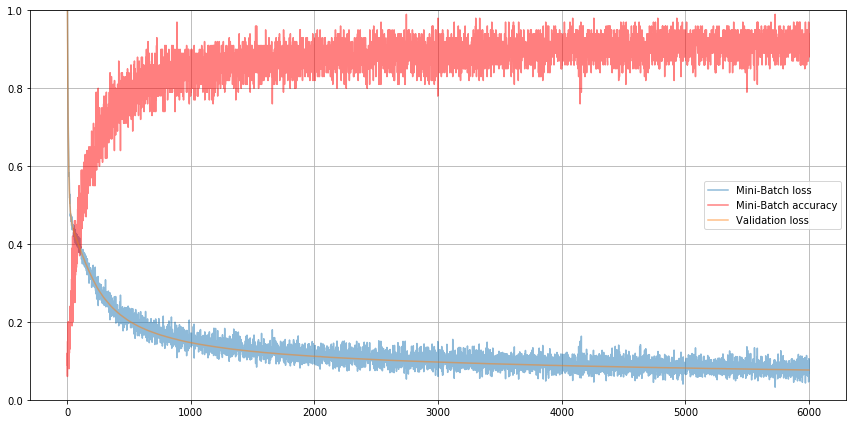

In [26]:
#
#   Plot Loss, Accuracy
#
print(expstr)
fig, ax = plt.subplots(figsize=[12,6])
ax.plot(batches['iter'], batches['loss'], label='Mini-Batch loss', alpha=.5)
ax.plot(batches['iter'], batches['acc'], label='Mini-Batch accuracy', color='red', alpha=.5)
ax.plot(valids['iter'], valids['loss'], label='Validation loss', alpha=.5)

ax.legend()
ax.set_ylim(0, 1)
ax.grid()

plt.tight_layout()
plt.show;

---

In [27]:
def plot_class_coverage(y, y_hat, axis=None):
    #
    #   Per-class accuracy
    #
    assert y.ndim == 2 and y_hat.ndim == 2
    assert y.shape == y_hat.shape
    
    nb_classses = y.shape[-1]
    
    y_correct = np.argmax(y, axis=-1) == np.argmax(y_hat, axis=-1)
    classes_correct = []
    classes_all = []
    for i in range(nb_classses):
        is_y_class_i = y_correct * (np.argmax(y, axis=-1)==i)
        nb_correct_class_i = np.sum(is_y_class_i)
        classes_correct.append(nb_correct_class_i)
        classes_all.append(np.count_nonzero(np.argmax(y, axis=-1)==i))
    classes_correct = np.array(classes_correct)
    classes_all = np.array(classes_all)

    if axis is None:
        fig, axis = plt.subplots()
    
    axis.bar(range(10), classes_all, label='All Member')
    axis.bar(range(10), classes_correct, label='Correctly Predicted')
    axis.legend(loc=3)

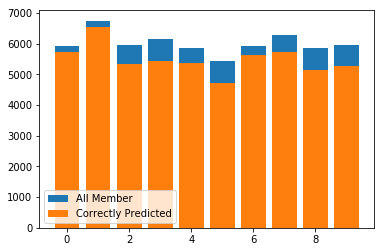

In [28]:
y_hat, _ = model.eval_batch(train_x, train_y)
plot_class_coverage(train_y, y_hat)

# Weight Plots

In [29]:
def running_mean(x, n):
    return np.array([ np.mean(x[max(i-n+1, 0): i+1]) for i in range(len(x))])

In [30]:
def running_std(x, n):
    return np.array([ np.std(x[max(i-n+1, 0): i+1]) for i in range(len(x))])

---

### Hidden

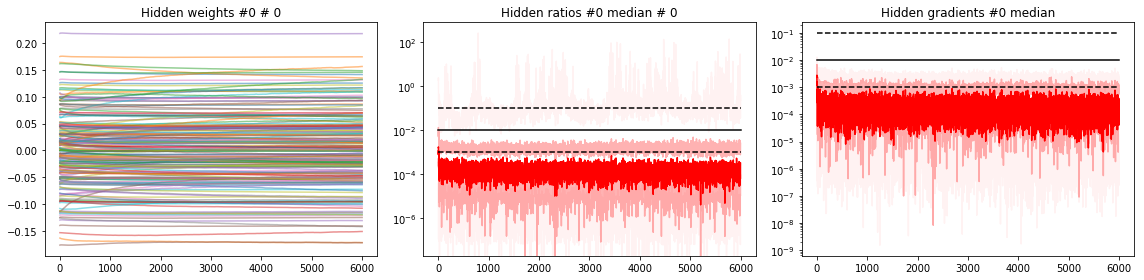

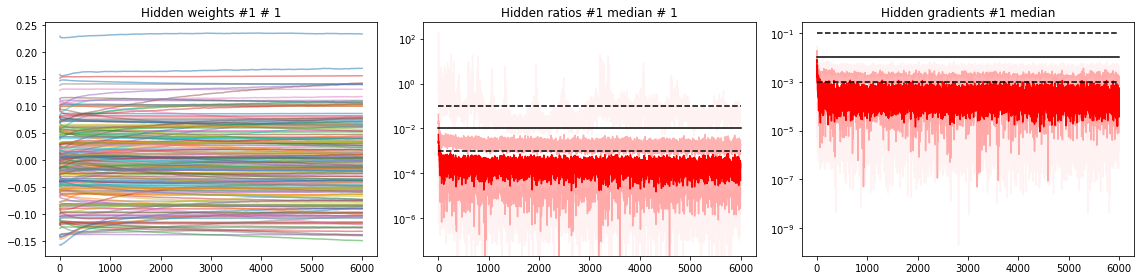

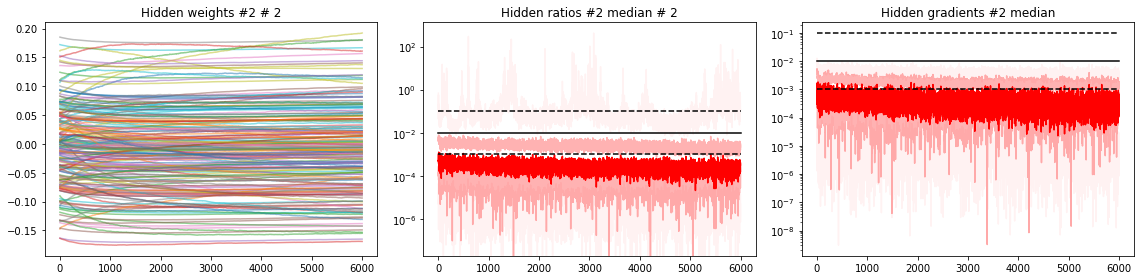

In [31]:
plotann.show_neurons_weights(tr_hid_W, tr_hid_dW, neurons=range(3),
                            title_prefix='Hidden', color='red', figsize=[16,4])

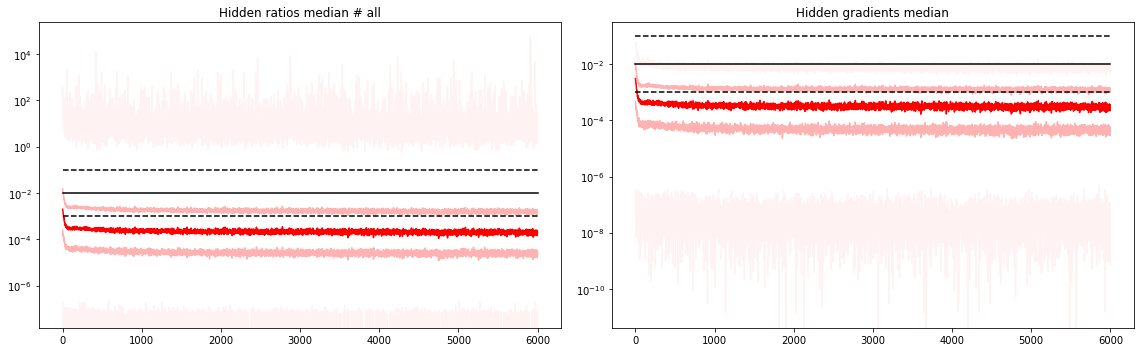

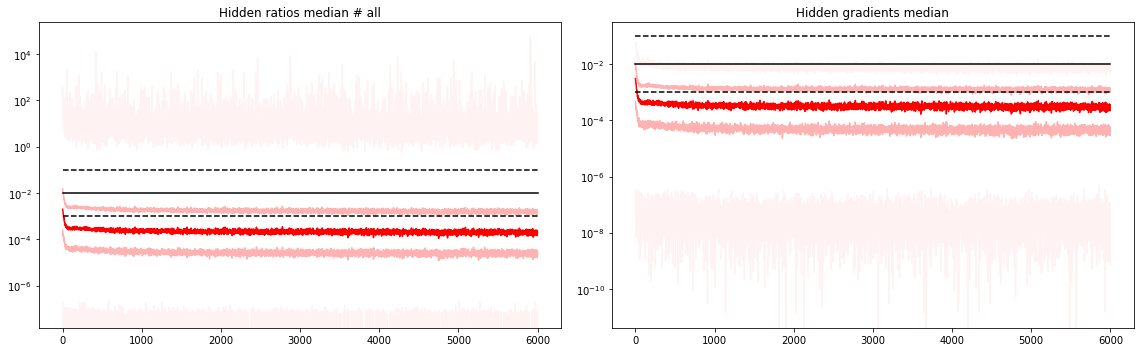

In [32]:
plotann.show_layer_summary(tr_hid_W, tr_hid_dW,
                           title_prefix='Hidden', color='red', figsize=[16,5])

### Output

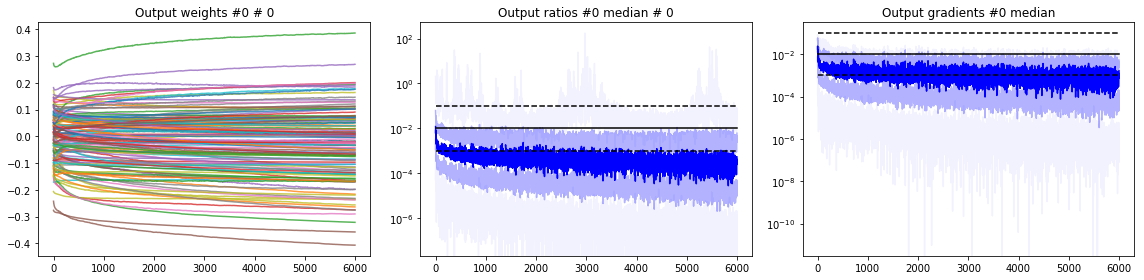

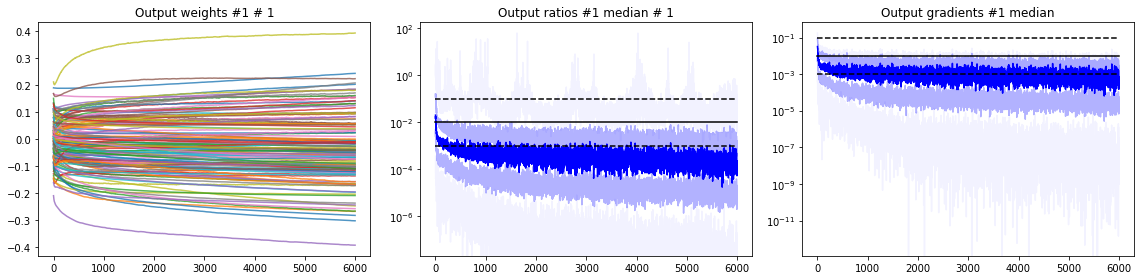

In [33]:
plotann.show_neurons_weights(tr_out_W, tr_out_dW, neurons=range(2),
                            title_prefix='Output', color='blue', figsize=[16,4])

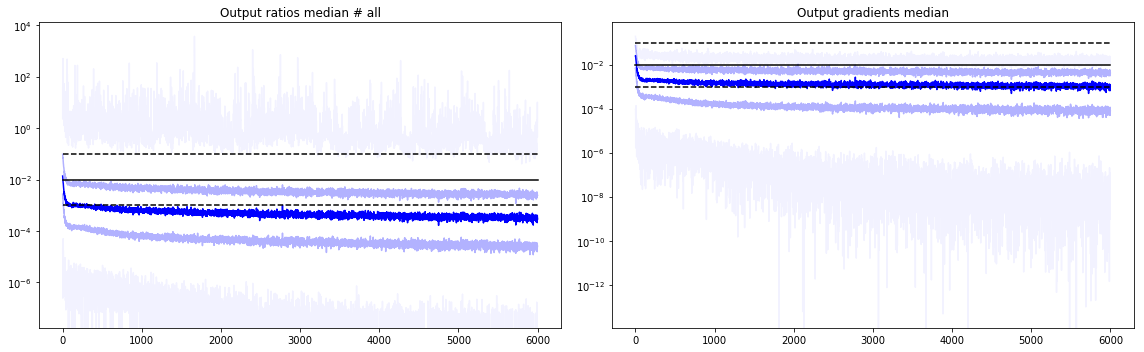

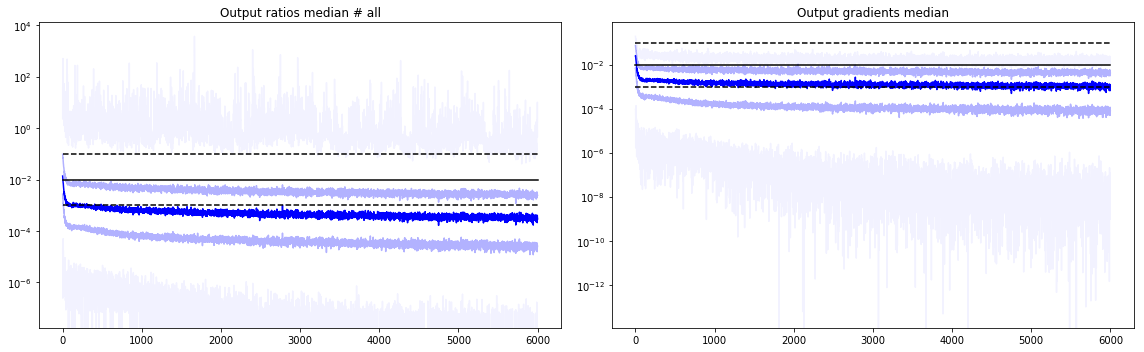

In [34]:
plotann.show_layer_summary(tr_out_W, tr_out_dW, title_prefix='Output', color='blue', figsize=[16,5])

# Activations

### Hidden

In [35]:
es = len(train_x)

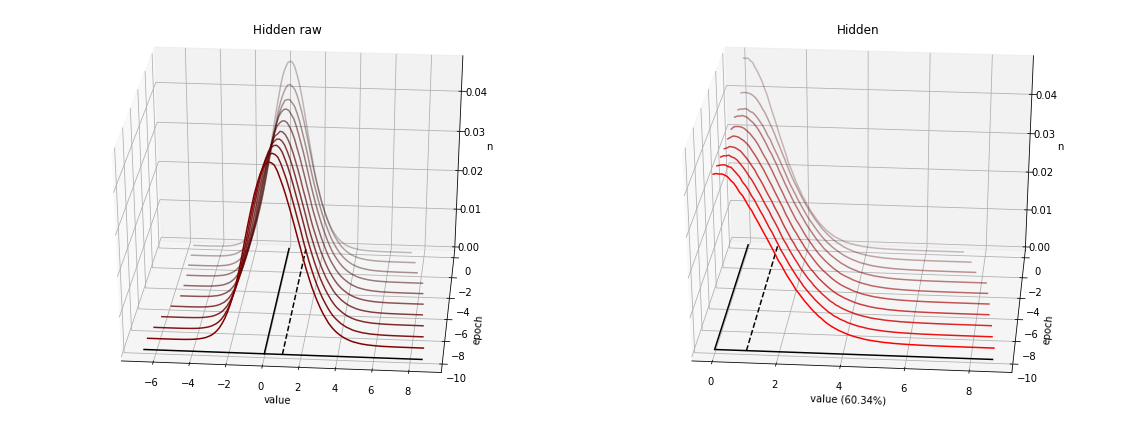

In [36]:
plotann.show_layer_activations(tr_hid_z, epoch_size=es, activation_function=act_fun,
                               title_prefix='Hidden', color=(1,0,0,1), figsize=[16,6])

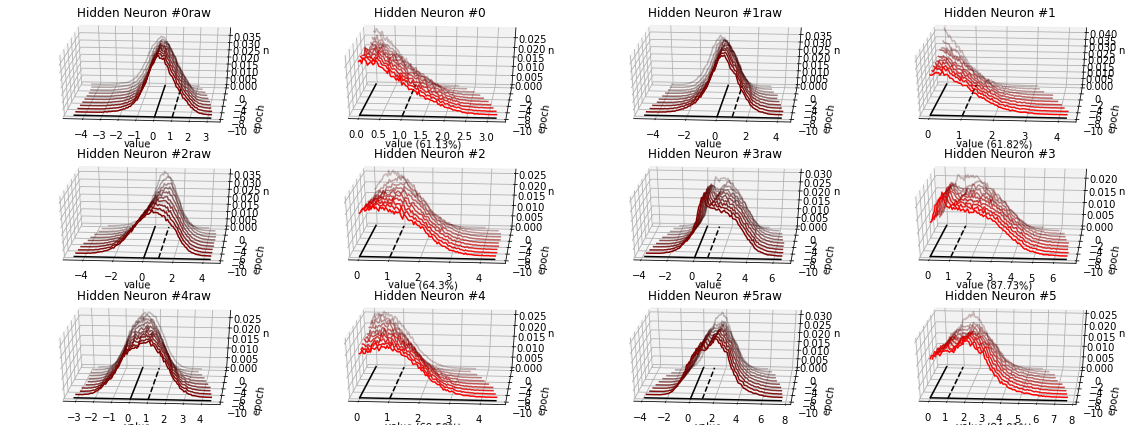

In [37]:
plotann.show_neurons_activations(tr_hid_z, epoch_size=es, activation_function=act_fun, neurons=range(6),
                                 title_prefix='Hidden', color=(1,0,0,1))

---

### Output

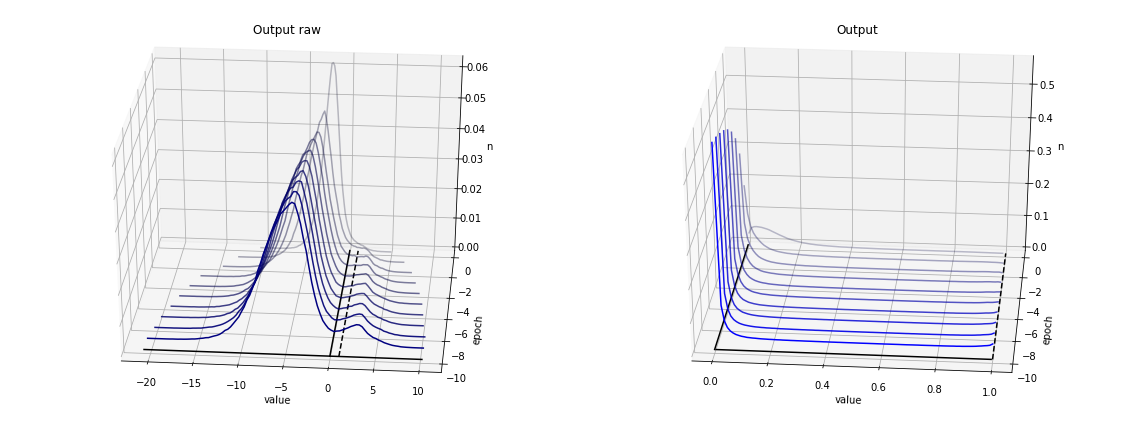

In [38]:
plotann.show_layer_activations(tr_out_z, epoch_size=es, activation_function='sigmoid',
                               title_prefix='Output', color=(0,0,1,1), figsize=[16,6])

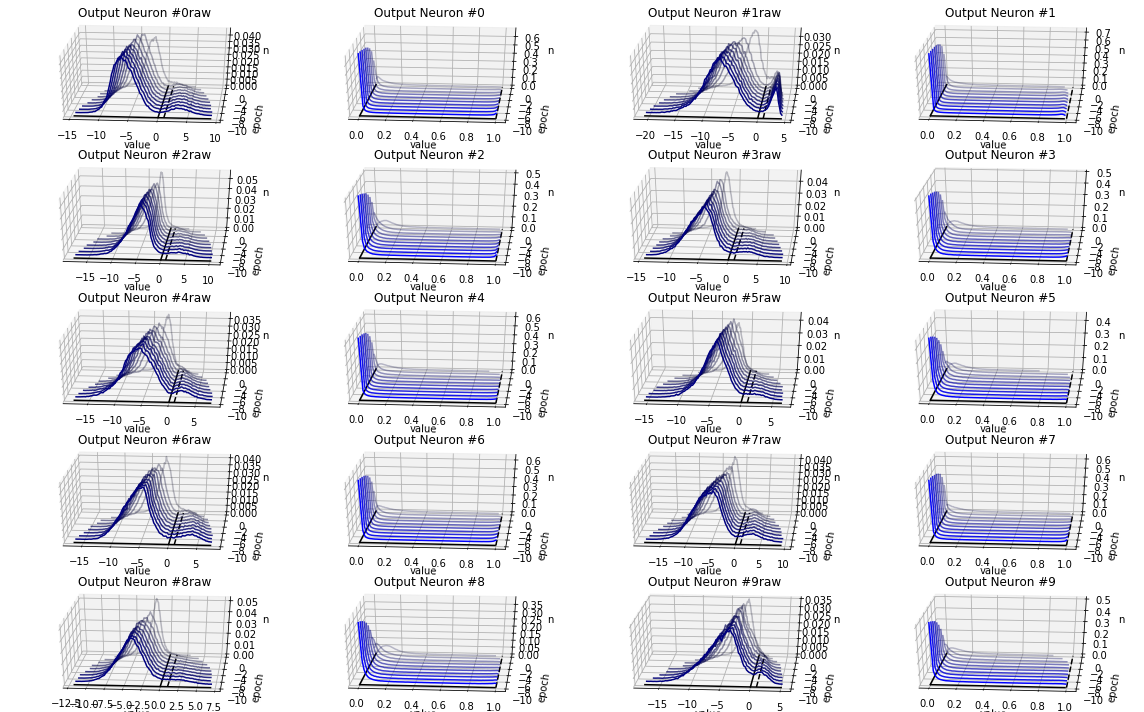

In [39]:
plotann.show_neurons_activations(tr_out_z, epoch_size=es, activation_function='sigmoid', neurons=range(tr_out_z.shape[-1]),
                                 title_prefix='Output', color=(0,0,1,1))